<a href="https://colab.research.google.com/github/wldopie/ESAA/blob/main/HW_221114.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **9.5 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트**
  - 유명한 영화 데이터 정보 사이트인 IMDB의 많은 영화 중 주요 5000개 영화에 대한 메타 정보를 새롭게 가공해 캐글에서 제공하는 데이터 세트
  - 이 TMDB 5000 데이터 세트에 기반해 콘텐츠 기반 필터링을 수행해보자.

---



### **9.5.1 장르 속성을 이용한 영화 콘텐츠 기반 필터링**
  - 콘텐츠 기반 필터링
    - 사용자가 특정 영화를 감상하고 그 영화를 좋아했다면, 그 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천하는 것
    - 영화(또는 상품/서비스)간의 유사성을 판단하는 기준이 영화를 구성하는 다양한 콘텐츠(장르, 감독, 배우, 평점, 키워드, 영화 설명)를 기반으로 하는 방식

  - 콘텐츠 기반 필터링 추천 시스템을 영화를 선택하는 데 중요한 요소인 장르 속성을 기반으로 만들어 보자.

  - 장르 칼럼 값의 유사도를 비교한 뒤, 그중 높은 평점을 가지는 영화를 추천하는 방식이다.

---

### **9.5.2 데이터 로딩 및 가공**

In [2]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv('/content/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


  - 영화 제목, 개요, 인기도, 평점 등 영화에 대한 다양한 메타 정보를 가지고 있다.
  - 이 중 콘텐츠 기반 필터링 추천 분석에 사용할 `주요 칼럼만 추출`해 새롭게 DataFrame으로 만들어 보자.
    - 주요 칼럼은 `id`, 영화제목 `title`, 영화 장르 `genres`, 평균 평점인 `vote_average`, 평점 투표 수인 `vote_count`, 영화의 인기도인 `popularity`, 영화를 설명하는 주요 키워드인 `keywords`, 영화에 대한 개요 설명인 `overview`이다.

In [3]:
movies_df = movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 
                    'popularity', 'keywords', 'overview']]

  - genres, keywords 등과 같은 칼럼을 보면 파이썬 리스트 내부어 여러 개의 딕셔너리가 있는 형태의 문자열로 표기되어 있다. 이는 한꺼번에 여러 개의 값을 표현하기 위한 표기 방식이다.
  - 해당 칼럼들이 DataFrame으로 만들어질 때 단순히 문자열 형태로 로딩되므로, 이 칼럼을 가공하지 않고는 필요한 정보를 추출할 수가 없다. 
  - 따라서 해당 칼럼들이 어떤 형태로 되어 있는지 확인해 보자.

In [4]:
pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


  - 위와 같이 genres 칼럼은 여러 개의 개별 장르 데이터를 가지고 있고, 이 개별 장르의 명칭은 딕셔너리의 키인 'name'으로 추출할 수 있다.
  - genres 칼럼의 문자열을 분해해서 개별 장르를 파이썬 리스트 객체로 추출해보자.
  - 파이썬 `ast 모듈`의 `literal_eval()` 함수를 이용하면 이 문자열을 `문자열이 의미하는 list[dict1, dict2]` 객체로 만들 수 있다.

In [5]:
from ast import literal_eval
movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

  - 이제 `genres 칼럼`에서 ['Action', 'Adventure']와 같은 `장르명만 리스트 객체로 추출`해보자.

In [6]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : [ y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [ y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


---

### **9.5.3 장르 콘텐츠 유사도 측정**
  - `장르별 유사도를 측정`하는 방법
    - `genres를 문자열로 변경`한 뒤, 이를 `CountVectorizer로 피처 벡터화한 행렬 데이터` 값을 `코사인 유사도로 비교`하는 것

  - genres 칼럼을 기반으로 한 콘텐츠 기반 필터링 구현 단계
    1. 문자열로 변환된 genres 칼럼을 Count 기반으로 피처 벡터화 변환한다.
    2. genres 문자열을 피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교한다. 이를 위해 데이터 세트의 레코드별로 타 레코드와 장르에서 코사인 유사도 값을 가지는 객체를 생성한다.
    3. 장르 유사도가 높은 영화 중에 평점이 높은 순으로 영화를 추천한다.

  - 먼저 `genres 칼럼을 문자열로 변환`한 뒤, 사이킷런의 `CountVectorizer를 이용해 피처 벡터 행렬`로 만든다.
  
  - 리스트 객체 값으로 구성된 genres 칼럼을 `apply(lambda x : (' ').join(x))를 적용`해 `개별 요소를 공백 문자로 구분하는 문자열로 변환`해 별도의 칼럼인 genres_listeral 칼럼으로 저장한다.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df = 0, ngram_range = (1, 2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


  - CountVectorizer로 변환해 4803개의 레코드와 276개의 개별 단어 피처로 구성된 피처 벡터 행렬이 만들어졌다.
  
  - 이렇게 생성된 피처 벡터 행렬에 사이킷런의 `cosine_similarity()`를 이용해 `코사인 유사도를 계산`한다.

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:1])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]]


  - movies_df를 장르 기준으로 콘텐츠 기반 필터링을 수행하려면 movies_df의 개별 레코드에 대해서 `가장 장르 유사도가 높은 순으로 다른 레코드를 추출`해야 하는데, 이를 위해 앞에서 생성한 genre_sim 객체를 이용한다.
  - `genre_sim 객체의 기준 행별`로 `비교 대상이 되는 행의 유사도 값이 높은 순으로 정렬`된 행렬의 `위치 인덱스 값`을 추출한다. 
    - `argsort()[:, ::-1]`을 이용하면 유사도가 높은 순으로 정리된 genre_sim 객체의 비교 행 위치 인덱스 값을 간편하게 얻을 수 있다.

In [9]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


  - 0번 레코드의 경우, 자신인 0번 레코드를 제외하면 3494번 레코드가 가장 유사도가 높고, 그 다음이 813번 레코드이며, 가장 유사도가 낮은 레코드는 2401번 레코드라는 뜻이다.

---

### **9.5.4 장르 콘텐츠 필터링을 이용한 영화 추천**
  - 이제 `장르 유사도에 따라 영화를 추천하는 함수`를 생성해보자.


In [10]:
def find_sim_movie(df, sorted_ind, title_name, top_n = 10):
  # 인자로 입력된 movies_df DataFrame에서 'title' 칼럼이 입력된 title_name 값인 DataFrame 추출
  title_movie = df[df['title'] == title_name]

  # title_named을 가진 DataFrame의 index 객체를 ndarray로 반환하고
  # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
  title_index = title_movie.index.values
  similar_indexes = sorted_ind[title_index, :(top_n)]

  # 추출된 top_n index 출력, top_n index는 2차원 데이터
  # DataFrame에서 index로 사용하기 위해서 1차원 array로 변경
  print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

  - `find_sim_movie()` 함수를 이용해 영화 `'대부'와 장르별로 유사한 영화 10개`를 추천해 보자.

In [11]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


  - 대부 2편, 좋은 친구들 등 대부를 재미있게 봤다면 추천해야 할 영화도 있지만, 낯선 영화도 많다.
  - 라이트 슬리퍼, Mi America, Kids 등 대부를 좋아하는 고객에게 섣불리 추천하기에는 이해하기 어려운 영화도 있다. 따라서 개선이 필요하다.

  - 이번에는 더 많은 후보군을 선정한 뒤, `영화의 평점에 따라 필터링해서 최종 추천`하는 방식으로 변경해 보자.
  - 이를 위해 vote_average 값을 이용한다.
    - vote_average의 경우, 평가에 참여한 관객의 수에 따라 매우 왜곡된 데이터를 가질 수 있으므로 이를 확인하기 위해 `sort_values()`를 이용해 `평점('vote_average')을 오름차순으로 정렬`해서 10개만 출력해보자.

In [12]:
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average', ascending = False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


  - 이렇듯 왜곡된 평점 데이터를 보완할 수 있도록 평점에 평가 횟수를 반영할 수 있는 새로운 평가 방식이 필요하다.
  - 이를 위해 IMDB에서는 평가 횟수에 대한 가중치가 부여된 평점 방식을 사용하며, 가중 평점의 공식은 다음과 같다.
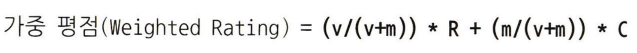 

  - 각 변수의 의미는 다음과 같다.
    - v : 개별 영화에 평점을 투표한 횟수(`vote_count`)
    - m : 평점을 부여하기 위한 최소 투표 횟수
    - R : 개별 영화에 대한 평균 평점(`vote_average`)
    - C : 전체 영화에 대한 평균 평점(`vote_average.mean()`)

In [13]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C :', round(C, 3), 'm :', round(m, 3))

C : 6.092 m : 370.2


  - 이제 기존 평점을 새로운 가중 평점으로 변경하는 함수를 생성하고, 이를 이용해 새로운 평점 정보인 'vote_weighted' 값을 만들어 보자.

In [18]:
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
  v = record['vote_count']
  R = record['vote_average']

  return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )

movies_df['weighted_vote'] = movies_df.apply(weighted_vote_average, axis = 1) 

In [19]:
movies_df[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values('weighted_vote', ascending = False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


  - 이제 새롭게 정의된 평점 기준에 따라 영화를 추천해 보자.
  - 장르 유사성이 높은 영화를 top_n의 2배수만큼 후보군으로 선정한 뒤에, weighted_vote 칼럼 값이 높은 순으로 top_n만큼 추출하는 방식으로 find_sim_movie() 함수를 변경한다.
  - find_sim_movie()를 이용해 다시 한 번 '대부'와 유사한 영화를 콘텐츠 기반 필터링 방식으로 추천해보자.

In [20]:
def find_sim_movie(df, sorted_ind, title_name, top_n = 10):
  title_movie = df[df['title'] == title_name]
  title_index = title_movie.index.values

  # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes = sorted_ind[title_index, :(top_n * 2)]
  similar_indexes = similar_indexes.reshape(-1)
  # 기준 영화 인덱스는 제외
  similar_indexes = similar_indexes[similar_indexes != title_index]

  # top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote', ascending = False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427


  - 이전에 비해 훨씬 나은 영화가 추천됐음을 확인할 수 있다.